In [1]:
import matplotlib.image as image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import feature, img_as_ubyte
from skimage.measure import ransac
from skimage.transform import warp, ProjectiveTransform, PolynomialTransform, rotate
from skimage.color import rgb2gray
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from sklearn.cluster import KMeans
from tslearn.clustering import KernelKMeans
import alphashape
import warnings
from descartes import PolygonPatch

from Dino_Images import *

In [2]:
# Source files
DI = Dino_Images()

# Place holder
ORDER = np.arange(DI.num_images + 1)
ORDER[-1] = 0

## Background Removal

In this section, we want to compare different background remove procedure for get the best result. The reason behind segementing the background from the object is to make sure we only perform 3d reconstruction on the object instead of everything else. 

### Stereo Depth Matching Segementation 

Since we have stereo images, one of the naive way of performing 

In [3]:
def background_remover_depth(imgL, imgR, TL, TR, threshold=0.0005, min_d=5):
    
    T_abs = TR - TL
    if not np.all(np.abs(T_abs) < 1):
        warnings.warn("The absolute translation is too small")
    
    # Convert image into uint8 with greyscale
    imgL_grey = cv2.cvtColor(imgL, cv2.COLOR_RGB2GRAY) 
    imgR_grey = cv2.cvtColor(imgR, cv2.COLOR_RGB2GRAY) 
    
    # Match points using corner harris
    keypointsL = corner_peaks(corner_harris(imgL_grey), threshold_rel=threshold, min_distance=min_d)
    keypointsR = corner_peaks(corner_harris(imgR_grey), threshold_rel=threshold, min_distance=min_d)

    extractor = BRIEF()

    extractor.extract(imgL_grey, keypointsL)
    keypointsL = keypointsL[extractor.mask]         
    descriptorsL = extractor.descriptors

    extractor.extract(imgR_grey, keypointsR)
    keypointsR = keypointsR[extractor.mask]
    descriptorsR = extractor.descriptors

    matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)
    
    # Compute the imR projection
    data = (np.flip(keypointsR[matchesLR[:,1]], axis=1), np.flip(keypointsL[matchesLR[:,0]], axis=1))
    model_robust, inliers = ransac(data, ProjectiveTransform, min_samples=4, residual_threshold=1, max_trials=5000)

    imR_rpj = warp(imgR_grey, model_robust.inverse)
    
    # Compute disparity map
    stereo = cv2.StereoBM_create(numDisparities=16, blockSize=5)
    disparity = stereo.compute(imgL_grey, img_as_ubyte(imR_rpj))

    return disparity + 16, imR_rpj

In [4]:
imgL_rotate = img_as_ubyte(rotate(DI.image_list[0], 90, resize = True))
imgR_rotate = img_as_ubyte(rotate(DI.image_list[1], 90, resize = True))
disparity, imR_rpj = background_remover_depth(imgL_rotate, imgR_rotate, DI.T_Matrix[0], DI.T_Matrix[1])

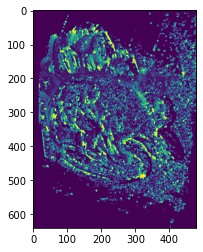

In [5]:
plt.imshow(disparity)

### K-means

In [6]:
def background_remover_k_clustering(img, Kinit = None, epi = 0.3):
    
    # Convert to integer and gray scale
    img_int = img_as_ubyte(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)) 

    # Create the lxy list 
    x, y = np.ogrid[:img_int.shape[1], :img_int.shape[0]]
    x_mtx, y_mtx = np.meshgrid(x, y)
    img_lxy = np.dstack((img_int, x_mtx * epi, y_mtx * epi))
    img_lxy_reshape = img_lxy.reshape(-1, 3)
    
    # Create the K init if not provided
    if not Kinit:
        h, w = img_int.shape
        Kinit = np.array([[0, 0, 0], [0, w, h], [255/2, w/2, h/2]])
        
    kmeans = KMeans(init=Kinit, n_clusters=3).fit(img_lxy_reshape)
    
    return kmeans.labels_.reshape(img_int.shape[0], img_int.shape[1])

/Users/jackxu/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


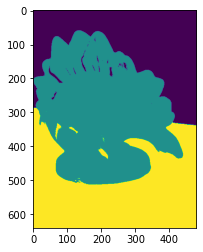

In [7]:
labels = background_remover_k_clustering(rotate(DI.image_list[0], 90, resize = True))
plt.imshow(labels)

## Sequencial Update

In [ ]:
'''
This function return triangluated points from a pair of images
    Input:
        imgF, imgS: The first and second images in rbg
        Ki, Ti, Ri: The camera calibration, trancription and rotation matrix
        pts_predefined: Points that have to be included in the first images
    Output:
        tri_pts: List of triangluated points in three dimensional
        matched_pts: The matched points pairs on the first/second images
'''
def pair_triangluate(imgF, imgS, KF, KS, TF, TS, RF, RS, pts_predefined = None):
    
    if not pts_predefined: # If predefined points included
        pass
    
    return None

In [ ]:
'''
This function return triangluated points from a sequence of images
    Input:
        images: The images abstract object descripted in the image.py file
        order: A order for transpassing the images
    Output:
        tri_pts: List of triangluated points in three dimensional
        matched_dicts: A dictionary which includes the matching pairs between pairs of images
'''
def sequencial_update(images, order = None):
    
    # Init
    tri_pts, matched_dicts = set(),{}
    imgs, K_Matrix, T_Matrix, R_Matrix = images.image_list, images.K_Matrix, images.T_Matrix, images.R_Matrix
    
    if not order: # If image order is not given then create one
        order = np.arange(DI.num_images + 1)
        order[-1] = 0
        
    # Transpassing the list in "order" by pair windows
    for i in range(1, len(order)):
        
        o, op = order[i], order[i-1]
        
        # Select the previous points
        pre_second_pts = matched_dicts.get(f"{order[i-2]}_{o}") if i > 1 else None
        
        # Perform pair triangluation
        curr_tri_pts, curr_matched_pts = \
        pair_triangluate(imgs[op], imgs[o], K_Matrix[op], K_Matrix[o], T_Matrix[op], T_Matrix[o], 
                         R_Matrix[op], R_Matrx[o], pts_predefined = pre_second_pts)
        
        # Update the list / dicts
        tri_pts.update(set(curr_tri_pts))
        matched_dicts.update({f"{op}_{o}": curr_matched_pts})
        
    return None